## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Step 1:Camera Calibration

In [95]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt
%matplotlib inline

##1-)Get the Object Points and Image Points

#Creating an array for object Points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)


objpoints=[] #3D points in real space 
imgpoints=[] #2D points in img space

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

## Step 2: Define a function to calibrate, undistort and warp images

In [98]:
left=[150,720] #left bottom most point of trapezium
right=[1250,720] #right bottom most point of trapezium
apex_left=[590,450] # left top most point of trapezium
apex_right=[700,450] # right top most point of trapezium

src=np.float32([left,apex_left,apex_right,right]) # Source Points for Image Warp
dst= np.float32([[200 ,720], [200  ,0], [980 ,0], [980 ,720]]) # Destination Points for Image Warp

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)
    
    return warped, M


## Step 3: Create binary tresholded image

In [104]:
def sobel_treshold(warpedImage, s_thresh=(100, 255), sx_thresh=(10, 150)):

    warpedImage = np.copy(warpedImage)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(warpedImage, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    yuv= cv2.cvtColor(warpedImage,cv2.COLOR_RGB2YUV)
    y_channel = yuv[:,:,0]
    
    # Sobel x
    gray = cv2.cvtColor(warpedImage, cv2.COLOR_RGB2GRAY) # Step 1- Convert to GrayScale
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,3) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]) & (l_channel >= s_thresh[0]) & (l_channel <= s_thresh[1]) & (y_channel >= s_thresh[0]) & (y_channel <= s_thresh[1])] = 1

    combined_binary = np.zeros_like(s_channel)
    combined_binary[(s_binary == 1) | (sxbinary == 1)  ] = 1
    return combined_binary

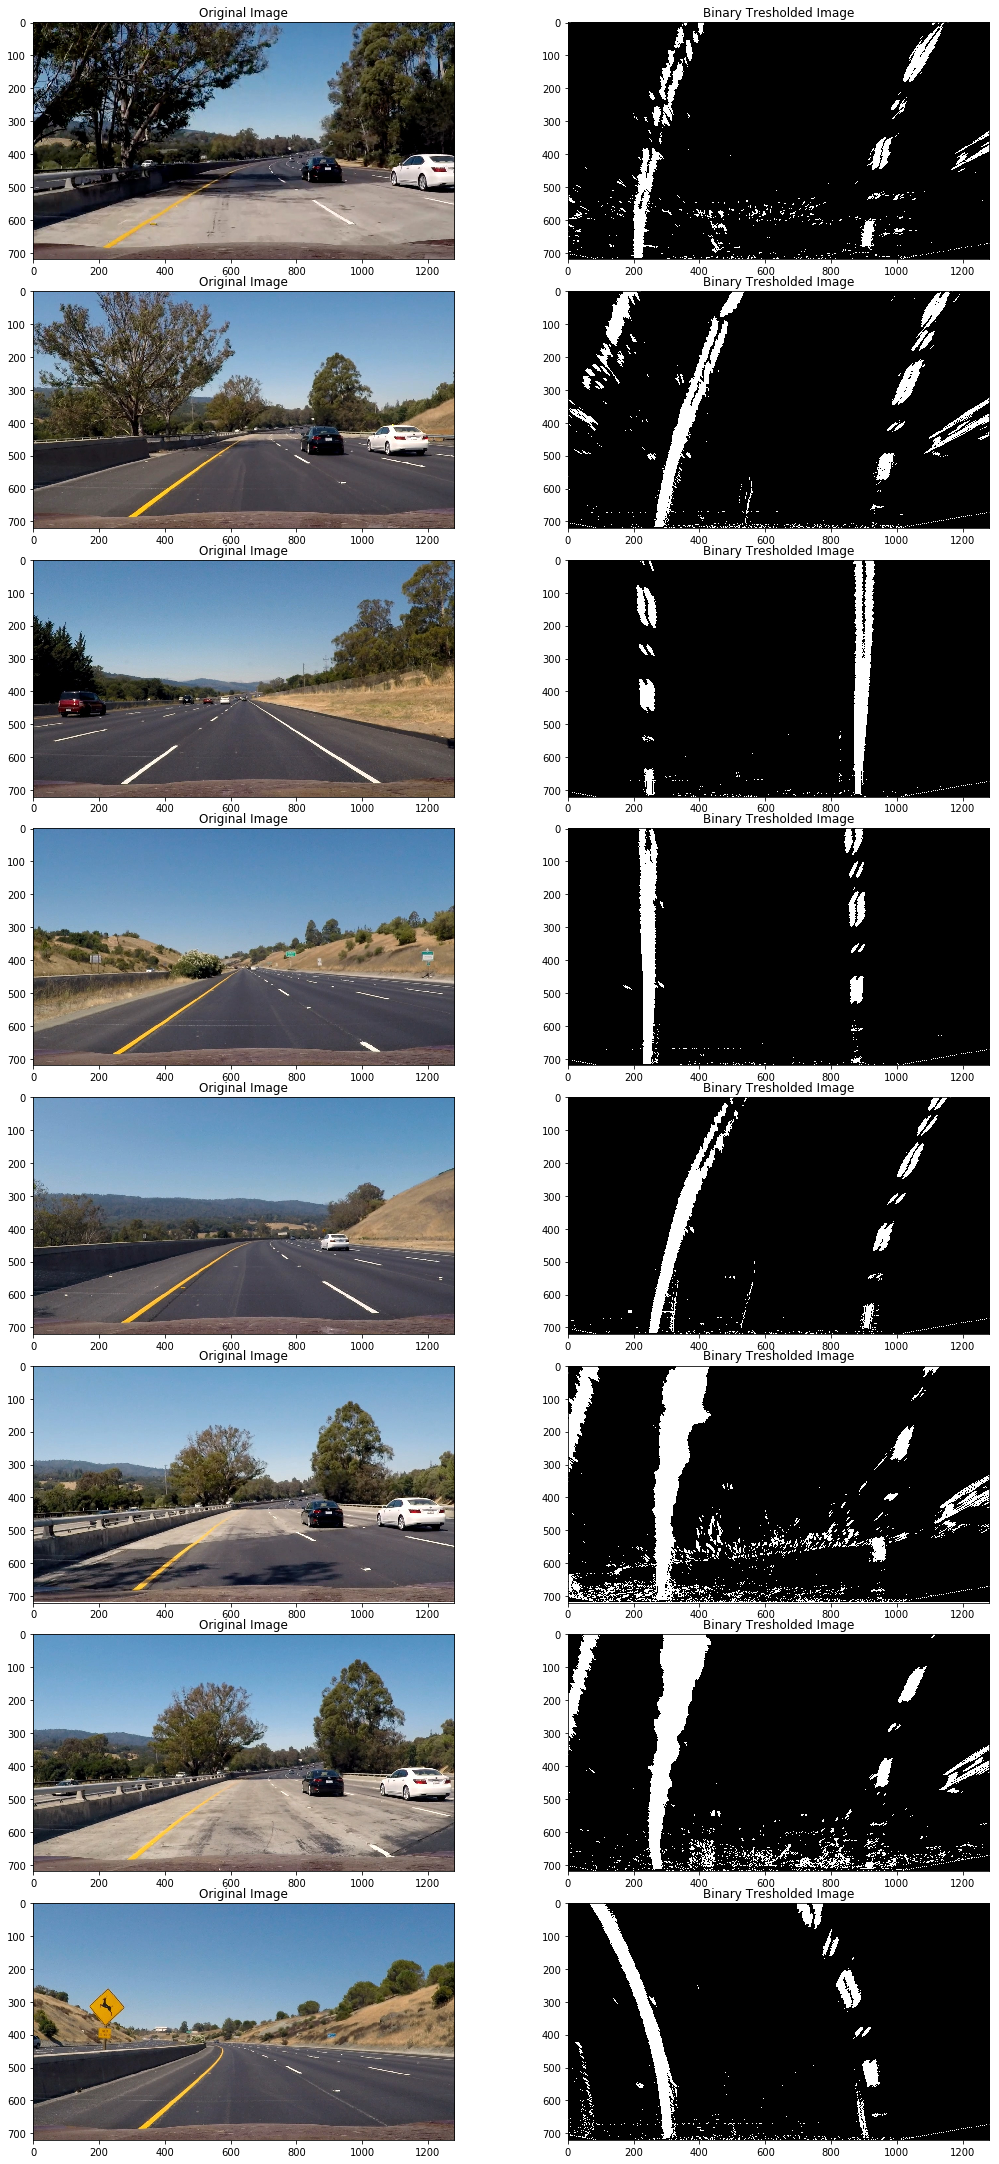

In [111]:
# Process Test Images

f, axes= plt.subplots(8,2,figsize=(15,30))
f.tight_layout()

images = glob.glob('test_images/*.jpg') # Reading Images from test_images folder
raw_images = []
warped_images= []

for index, image in enumerate(images):
    originalImage = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    raw_images.append(originalImage)
    axes[index,0].imshow(originalImage)
    axes[index,0].set_title("Original Image")
    
    warped, M = cal_undistort(originalImage, objpoints, imgpoints) # undistorting image 
    binary_warped = sobel_treshold(warped) #tresholding image
    warped_images.append(binary_warped)
    axes[index,1].set_title("Binary Tresholded Image")
    axes[index,1].imshow(binary_warped, cmap = 'gray')    

## Step 4: Detect lane pixels

In [113]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, out_img

## Step 5: Visualize sliding window

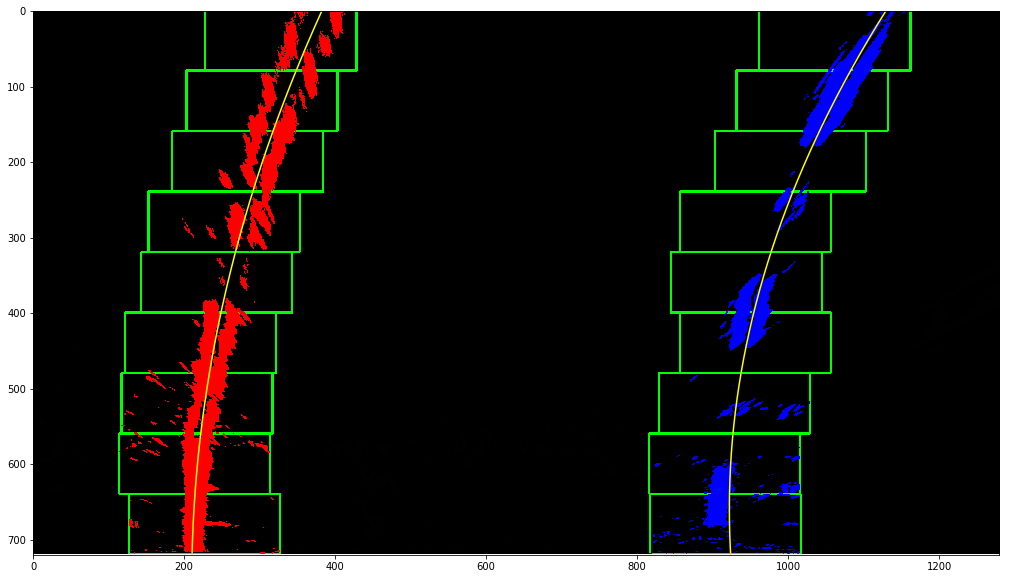

In [114]:
def visualizeSlidingWindow(binary_warped,left_fit,right_fit,left_lane_inds,right_lane_inds,out_img):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    plt.figure(figsize=(20,10))
    plt.imshow(out_img)
    #cv2.imwrite('output_images/'+'window' + str(index) +'.png', out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

binary = warped_images[0]
left_fit,right_fit,left_lane_inds,right_lane_inds,out_img = find_lane_pixels(binary)
visualizeSlidingWindow(binary,left_fit,right_fit,left_lane_inds,right_lane_inds,out_img)

## Step 6: Detect lane pixels and fit to find the lane boundary

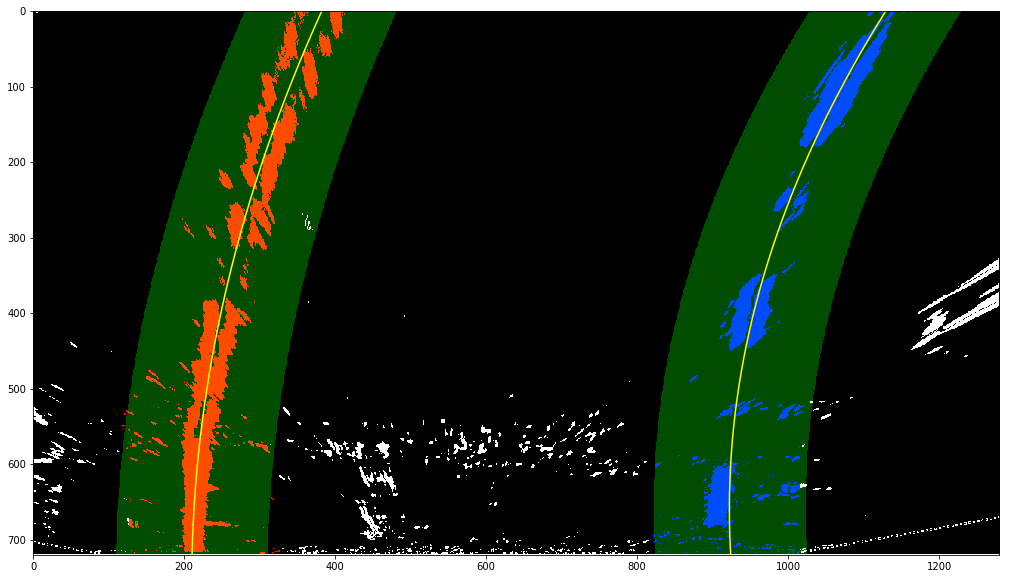

In [115]:
def search_around_poly(binary_warped, left_fit,right_fit, left_lane_inds, right_lane_inds,out_img):
    
    margin = 100
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
   
    
 
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    
    
    plt.figure(figsize=(20,10))
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
left_fit,right_fit,left_lane_inds,right_lane_inds,out_img = find_lane_pixels(binary)
search_around_poly(binary, left_fit,right_fit,left_lane_inds,right_lane_inds,out_img)

# View your output
#plt.imshow(binary)

## Step 7: Warp the detected lane boundaries back onto the original image.

In [116]:
def DrawLine(original_image, binary_warped, left_fit, right_fit):
    
    h,w= binary_warped.shape
    Minv = cv2.getPerspectiveTransform(dst, src)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 

    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.5, 0)
    return result

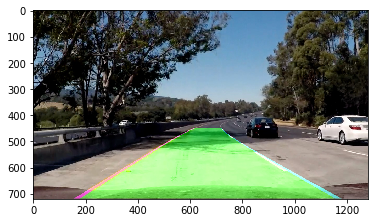

In [117]:
# testing it on test image

originalImage= raw_images[0]
returnedOutput =  find_lane_pixels(warped_images[0])
left_fit=returnedOutput[0]
right_fit=returnedOutput[1]
finalImage=DrawLine(originalImage,warped_images[0],left_fit,right_fit)
plt.imshow(finalImage)

## Step 8: Determine the curvature of the lane and vehicle position with respect to center

In [118]:
def measure_curvature(binary_warped,left_fit,right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    positionCar= binary_warped.shape[1]/2
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radius of curvature
    y_eval=np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    actualPosition= (left_lane_bottom + right_lane_bottom)/2
    
    distance= (positionCar - actualPosition)* xm_per_pix
    
    return (left_curverad + right_curverad)/2, distance

## Step 9: Define pipeline for all process

In [122]:
from random import randint
import datetime
import time
def pipeline(originalImage):
    
    #originalImage= cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)
    undistortedImage, M = cal_undistort(originalImage, objpoints, imgpoints )
    warpedImage = sobel_treshold(undistortedImage)
    returnedOutput =  find_lane_pixels(warpedImage)
    left_fit=returnedOutput[0]
    right_fit=returnedOutput[1]
    finalImage=DrawLine(originalImage, warpedImage,left_fit,right_fit)
    #VisualizeSlidingWindow(combinedImage, left_fit,right_fit, returnedOutput[2], returnedOutput[3],returnedOutput[4])
    #cv2.imwrite('./test/'+str(randint(0, 99999))+'.jpg',originalImage)
    
    radius, distance = measure_curvature(warpedImage,left_fit,right_fit)
    cv2.putText(finalImage,"Radius of Curvature is " + str(int(radius))+ "m", (100,100), 2, 1, (255,255,0),2)
    #print(distance)
    cv2.putText(finalImage,"Distance from center is {:2f}".format(distance)+ "m", (100,150), 2, 1, (255,255,0),2)
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y%m%d %H%M%S')

    #cv2.imwrite('output_images/'+str(st)+'.jpg',originalImage)
    
    #cv2.imwrite('output_images/'+str(st)+'_o.jpg',finalImage)
    
    newCombinedImage= np.dstack((warpedImage*255,warpedImage*255,warpedImage*255))
    finalImage[100:240,1000:1200, :]= cv2.resize(newCombinedImage, (200,140))
    #return cv2.cvtColor(finalImage, cv2.COLOR_BGR2RGB)
    return finalImage

## Step 10: Test pipeline

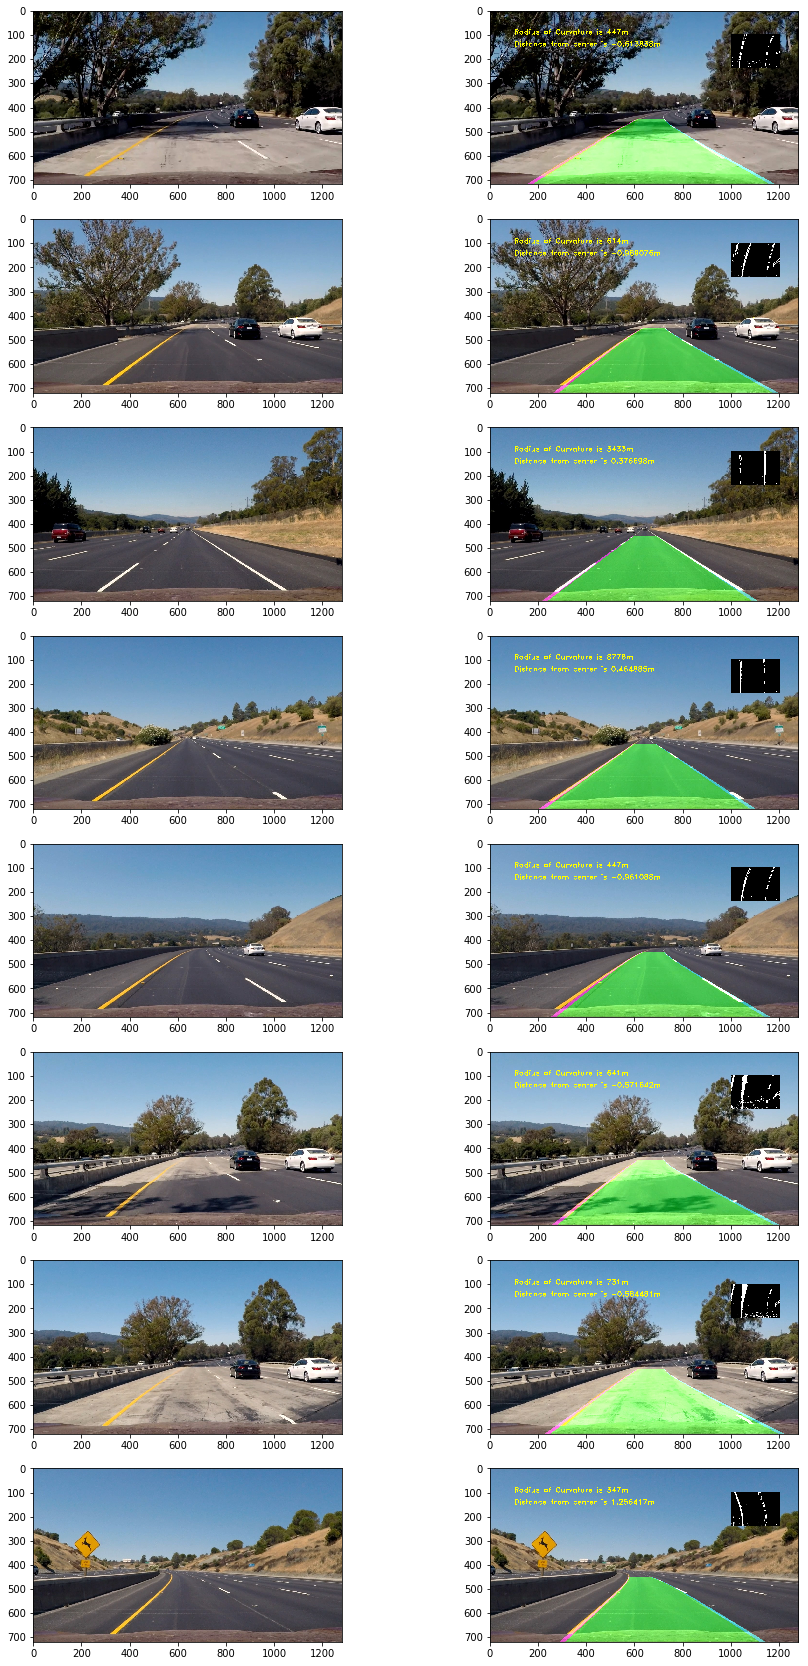

In [120]:
#testing on test images
f, axes= plt.subplots(8,2,figsize=(15,30))

images = glob.glob('test_images/*.jpg') # Reading Images from test_images folder

for index, image in enumerate(images):
    originalImage= cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    finalImage=pipeline(originalImage)
    cv2.imwrite('output_images/'+str(index)+'.jpg', cv2.cvtColor(finalImage,cv2.COLOR_BGR2RGB))
    axes[index,0].imshow(originalImage)
    axes[index,1].imshow(finalImage)

In [125]:
import moviepy
from moviepy.editor import VideoFileClip
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 13%|█▎        | 170/1261 [03:53<24:17,  1.34s/it]

KeyboardInterrupt: 

In [126]:

myclip = VideoFileClip("project_video_output.mp4")
myclip.write_gif("test.gif")



[MoviePy] Building file test.gif with imageio



 99%|█████████▉| 170/171 [01:28<00:00,  1.81it/s]
